# IMPORTANT!! 
## Make sure you have run the preprocessing script (`preprocessing/hog/main.py`) so that you have the necessary HOG data.

---

# KNN with HOG

Adding our own packages to the path so that they can be found.

In [94]:
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

Needed packages

In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support
from sklearn.model_selection import GridSearchCV
from preprocessing.hog import Flatten

## Loading Metadata

We load the hog metadata file in order to find the paths to the training and testing data.

In [96]:
hog_metadata_path = '../../data/hog/metadata.csv'
hog_metadata = pd.read_csv(hog_metadata_path, index_col=0)
hog_metadata.channels = hog_metadata.channels.astype(str)

## Grid Search for KNN

In [97]:
train_metadata = hog_metadata[(hog_metadata.type == 'train') & (hog_metadata.channels == channel)]
train = np.load(f'../../{train_metadata.data_path.values[0]}')
train_label = np.load(f'../../{train_metadata.label_path.values[0]}')

val_metadata = hog_metadata[(hog_metadata.type == 'dev') & (hog_metadata.channels == channel)]
val = np.load(f'../../{val_metadata.data_path.values[0]}')
val_label = np.load(f'../../{val_metadata.label_path.values[0]}')

parameters = {'n_neighbors':range(3, 15)}
knn = KNeighborsClassifier()
gs = GridSearchCV(knn, parameters)

pipeline = Pipeline([('gs', gs)])

pipeline.fit(np.vstack((train, val)), np.hstack((train_label, val_label)))

Pipeline(steps=[('gs',
                 GridSearchCV(estimator=KNeighborsClassifier(),
                              param_grid={'n_neighbors': range(3, 15)}))])

## Creating the KNN Pipeline

KNN expects a 2D array, so we need to flatten the image dimensions from `(samples, width, height)` into `(samples, width * height)`. Our custom `Flatten` class does this job for us.

In [98]:
pipeline = Pipeline([('knn', KNeighborsClassifier(n_neighbors=gs.best_params_['n_neighbors']))])

## Getting the data, fitting, scoring

We go through all of the channels, and fetch the train and test data associated with each. Then we fit, predict, and save the resulting confusion matrix.

We also create a `metrics` dictionary that will hold accuracy, precision, and recall scores.

In [99]:
confusion_matrices = {}
metrics = {'algorithm': ['KNN'] * 3,  'metrics': ['accuracy', 'precision', 'recall']}
for channel in hog_metadata.channels.unique():
    metrics[channel] = []

In [100]:
for channel in hog_metadata.channels.unique():
    train_metadata = hog_metadata[(hog_metadata.type == 'train') & (hog_metadata.channels == channel)]
    train = np.load(f'../../{train_metadata .data_path.values[0]}')
    train_label = np.load(f'../../{train_metadata.label_path.values[0]}')

    test_metadata = hog_metadata[(hog_metadata.type == 'test') & (hog_metadata.channels == channel)]
    test = np.load(f'../../{test_metadata.data_path.values[0]}')
    test_label = np.load(f'../../{test_metadata.label_path.values[0]}')
    
    pipeline.fit(train, train_label)
    
    test_pred = pipeline.predict(test)
    confusion_mat = confusion_matrix(test_label, test_pred)
    confusion_matrices[channel] = confusion_mat
    
    precision, recall, *_ = precision_recall_fscore_support(test_label, test_pred)
    accuracy = accuracy_score(test_label, test_pred)
    metrics[channel] += [accuracy, max(precision), max(recall)]

## Confusion Matrix

In [101]:
display_labels = ['No Glacier', 'Glacier']

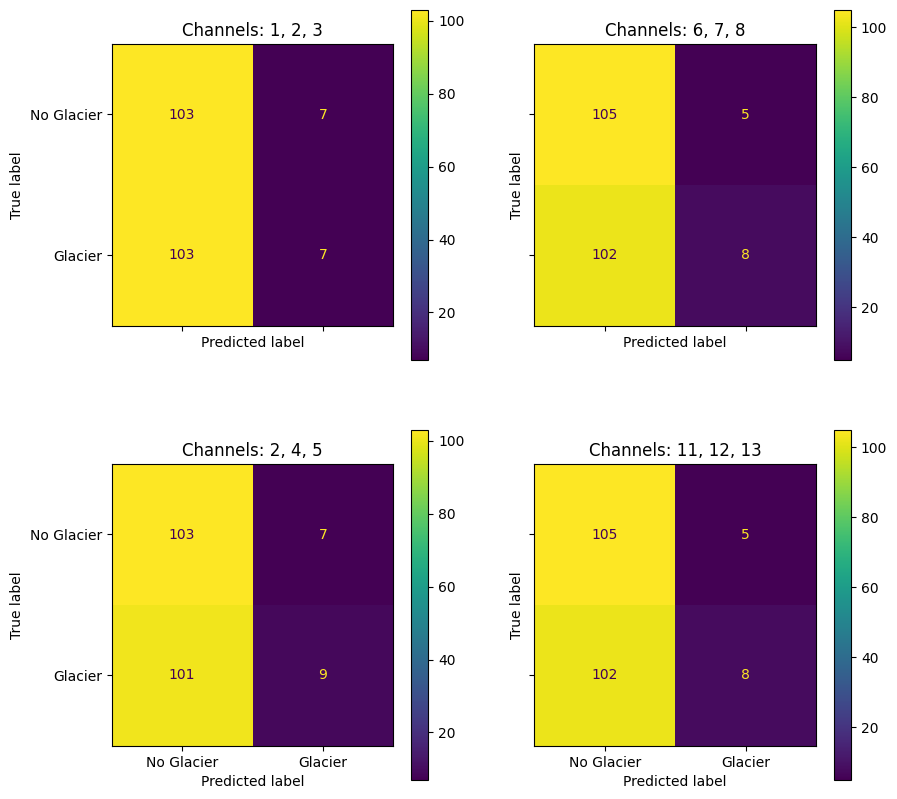

In [102]:
fig, axes = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True, figsize=(10, 10))

axes[0][0].set_title("Channels: 1, 2, 3")
axes[0][1].set_title("Channels: 6, 7, 8")
axes[1][0].set_title("Channels: 2, 4, 5")
axes[1][1].set_title("Channels: 11, 12, 13")

ConfusionMatrixDisplay(confusion_matrices['[1, 2, 3]'], display_labels=display_labels).plot(ax=axes[0][0])
ConfusionMatrixDisplay(confusion_matrices['[6, 7, 8]'], display_labels=display_labels).plot(ax=axes[0][1])
ConfusionMatrixDisplay(confusion_matrices['[2, 4, 5]'], display_labels=display_labels).plot(ax=axes[1][0])
ConfusionMatrixDisplay(confusion_matrices['[11, 12, 13]'], display_labels=display_labels).plot(ax=axes[1][1]);

## Result Dataset
Saving the different scores into a csv so that they can be used for plotting

In [103]:
metrics = pd.DataFrame(metrics)
metrics.to_csv('./knn_metrics.csv')

In [104]:
metrics

,algorithm,metrics,"[1, 2, 3]","[6, 7, 8]","[11, 12, 13]","[2, 4, 5]"
0,KNN,accuracy,0.500000,0.513636,0.513636,0.509091
1,KNN,precision,0.500000,0.615385,0.615385,0.562500
2,KNN,recall,0.936364,0.954545,0.954545,0.936364
